# Supervised Machine Learning: Regression

In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
diamonds = sns.load_dataset('diamonds')

from sklearn.model_selection import train_test_split
X = diamonds.drop(columns=['price'])
y = diamonds['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=8)
X_train.head()

,carat,cut,color,clarity,depth,table,x,y,z
34530,0.33,Ideal,G,VVS1,62.0,56.0,4.45,4.48,2.77
26173,2.00,Very Good,I,VS2,59.5,62.0,8.13,8.21,4.86
20038,0.30,Good,H,SI1,63.4,58.0,4.21,4.24,2.68
41661,0.54,Ideal,J,VVS1,62.2,54.0,5.23,5.25,3.26
42306,0.41,Premium,D,VVS2,62.5,58.0,4.72,4.75,2.96


## 1st iteration: dummy model and linear regression + regression errors

### Dummy model

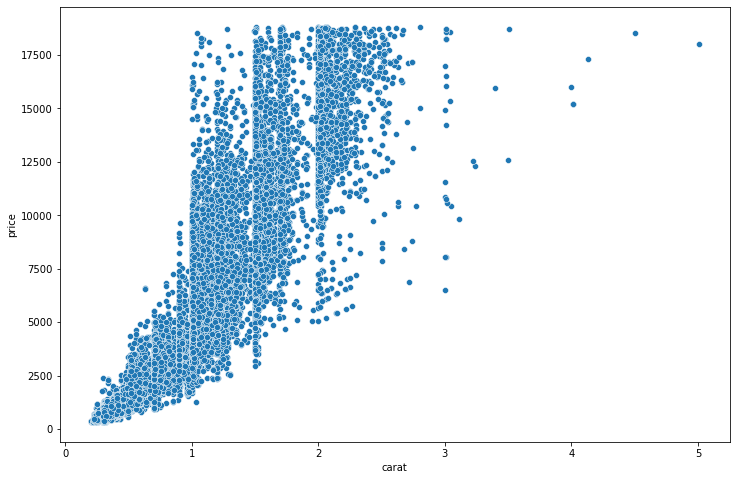

In [4]:
plt.subplots(figsize=(12, 8))
sns.scatterplot(x=X_train['carat'], y=y_train)
plt.show()

Based on the graph below I am going to create a real simple model:

$$
price = carat*4000
$$

In [5]:
def my_dummy_model(carat): 
    return carat * 4000

dummy_model_res = (
X_train
    .assign(
        preds = lambda x: my_dummy_model(x['carat']), 
        price = y_train
        )
    .assign(
        error = lambda x:  x['preds'] - x['price']
    )
)
dummy_model_res

,carat,cut,color,clarity,depth,table,x,y,z,preds,price,error
34530,0.33,Ideal,G,VVS1,62.0,56.0,4.45,4.48,2.77,1320.0,868,452.0
26173,2.00,Very Good,I,VS2,59.5,62.0,8.13,8.21,4.86,8000.0,15510,-7510.0
20038,0.30,Good,H,SI1,63.4,58.0,4.21,4.24,2.68,1200.0,421,779.0
41661,0.54,Ideal,J,VVS1,62.2,54.0,5.23,5.25,3.26,2160.0,1239,921.0
42306,0.41,Premium,D,VVS2,62.5,58.0,4.72,4.75,2.96,1640.0,1295,345.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10376,1.20,Premium,J,SI1,58.5,61.0,6.95,6.89,4.05,4800.0,4778,22.0
34949,0.31,Ideal,I,SI2,61.0,56.0,4.39,4.43,2.69,1240.0,379,861.0
18417,1.24,Premium,D,SI1,62.4,59.0,6.86,6.82,4.27,4960.0,7486,-2526.0
25940,2.01,Premium,G,SI1,61.8,59.0,8.15,8.09,5.02,8040.0,15105,-7065.0


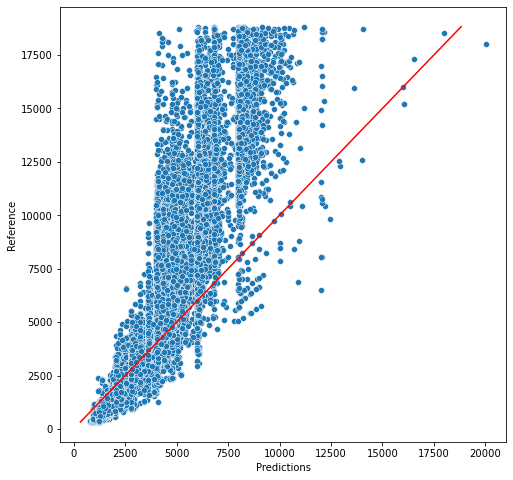

In [6]:
def plot_predictions(y_true, y_pred): 
    max_preds = min([max(y_pred.tolist()), max(y_true.tolist())])
    min_preds = min([min(y_pred.tolist()), min(y_true.tolist())])
    # plot
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=y_pred, y=y_true)
    sns.lineplot(x=[min_preds,max_preds], y=[min_preds, max_preds], color='red')
    plt.ylabel('Reference')
    plt.xlabel('Predictions')
    plt.show()
plot_predictions(dummy_model_res['price'], dummy_model_res['preds'])

### Creating our first Linear Model

In [7]:
np.array(X_train['carat']).reshape(-1, 1)

array([[0.33],
       [2.  ],
       [0.3 ],
       ...,
       [1.24],
       [2.01],
       [0.82]])

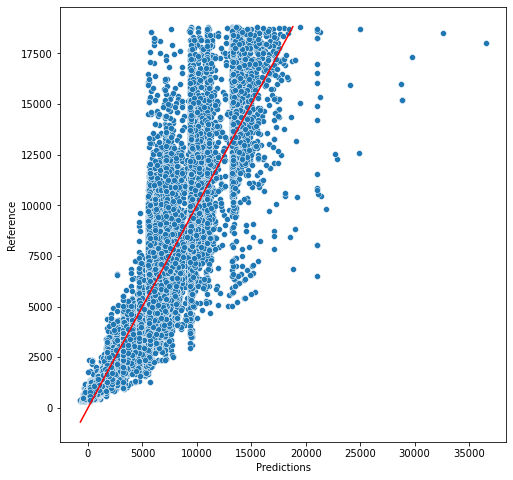

In [8]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(np.array(X_train['carat']).reshape(-1, 1), y_train)
plot_predictions(y_train, lm.predict(np.array(X_train['carat']).reshape(-1, 1)))

In [9]:
print(
    lm.coef_, 
    lm.intercept_
    )

[7752.35768657] -2254.51850373193


Linear model: 

$$
price = -2254.5185037319566 + carat * 7752.35768657
$$

### Results on test set

In [10]:
results = pd.DataFrame({
    'predictions':lm.predict(np.array(X_test['carat']).reshape(-1, 1)), 
    'true_values':y_test
})
results.head() 

,predictions,true_values
43149,2086.801801,1389
50113,1699.183916,2209
49263,3172.131877,2088
9661,5575.362760,4642
8500,6428.122105,4422


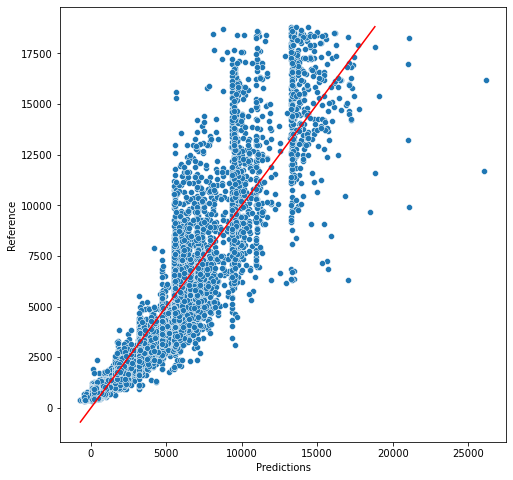

In [11]:
plot_predictions(results.true_values, results.predictions)

* Mean Squared Error (MSE): is calculated as the mean or average of the squared differences between predicted and expected target values.
$$MSE = \frac{1}{n}\sum_{i=1}^{n}(y_{i} - y_{e})^{2}$$

In [12]:
mse_pre = (results
               .assign(diff = lambda x: (x.true_values - x.predictions)**2)
               .agg({'diff':{'sum','count'}}))
mse = mse_pre.loc['sum'] / mse_pre.loc['count']
mse

diff    2.367452e+06
dtype: float64

In [13]:
# check our results with sklearn metrics
from sklearn.metrics import mean_squared_error
mean_squared_error(results.true_values, results.predictions)

2367452.0177661614

* Root Mean Squared Error (RMSE): 
$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_{i} - y_{e})^{2}}$$

In [14]:
rmse = (mse_pre.loc['sum'] / mse_pre.loc['count'])**0.5
rmse

diff    1538.652663
dtype: float64

In [15]:
# check our results with sklearn metrics
mean_squared_error(results.true_values, results.predictions)**0.5

1538.6526631329637

* Mean Absolute Error (MAE)
$$MAE = \frac{1}{n}\sum_{i=1}^{n} |y_{i} - y_{e}|$$

In [16]:
mae_pre = (results
               .assign(diff = lambda x: abs(x.true_values - x.predictions))
               .agg({'diff':{'sum','count'}}))
mae = mae_pre.loc['sum'] / mae_pre.loc['count']
mae

diff    1010.730354
dtype: float64

In [17]:
# check our results with sklearn metrics
from sklearn.metrics import mean_absolute_error
mean_absolute_error(results.true_values, results.predictions)

1010.7303536720527

* Mean Absolute Percentage Error (MAPE)

$$MAPE = \frac{1}{n}\sum_{i=1}^{n} |\frac{y_{i} - y_{e}}{y_{i}}|$$

In [18]:
# from sklearn.metrics import mean_absolute_percentage_error
# mean_absolute_percentage_error(results['true_values'], results['predictions'])


        MSE: 2367452.0177661614
        RMSE: 1538.6526631329637
        MAE: 1010.7303536720527
        
18818 340


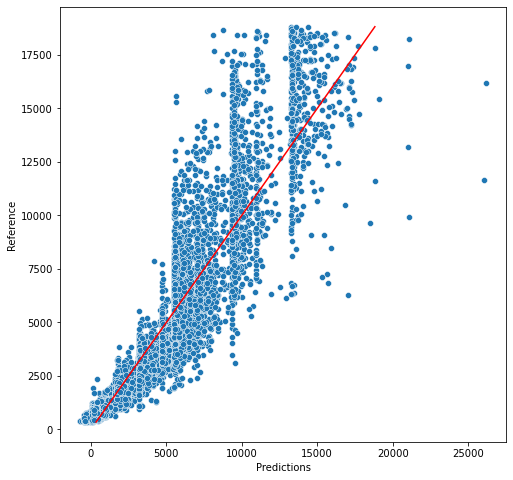

In [19]:
def plot_predictions(y_true, y_pred): 
    print(
        f"""
        MSE: {mean_squared_error(y_true, y_pred)}
        RMSE: {mean_squared_error(y_true, y_pred)**0.5}
        MAE: {mean_absolute_error(y_true, y_pred)}
        """
    )
    max_preds = min([max(y_pred.tolist()), max(y_true.tolist())])
    min_preds = max([min(y_pred.tolist()), min(y_true.tolist())])
    print(max_preds, min_preds)
    # plot
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=y_pred, y=y_true)
    sns.lineplot(x=[min_preds,max_preds], y=[min_preds, max_preds], color='red')
    plt.ylabel('Reference')
    plt.xlabel('Predictions')
    plt.show()

plot_predictions(y_test, results['predictions'])

Have this errors a normal distribution?

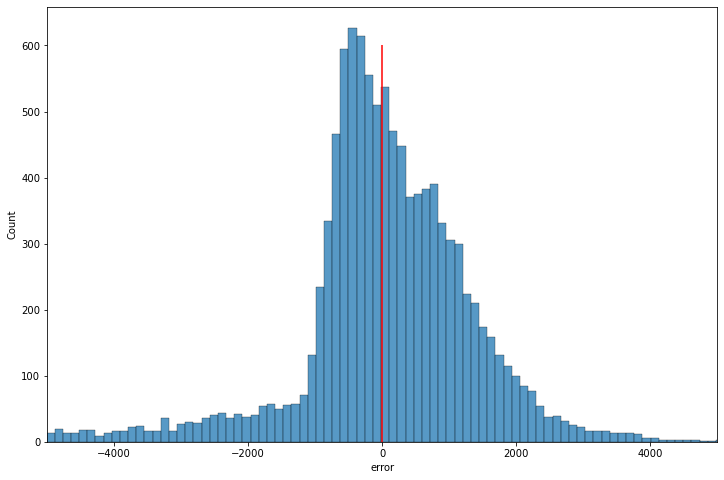

In [20]:
p_df = results.assign(error = lambda x: x['predictions'] - x['true_values'])

plt.subplots(figsize=(12, 8))
sns.histplot(p_df['error'])
plt.vlines(x=0, ymin=0, ymax=600, color='red')
# big problems with outliers
plt.xlim(-5000, 5000)
plt.show()
# skewness to the right, my model tend to predict a higer price then it should be

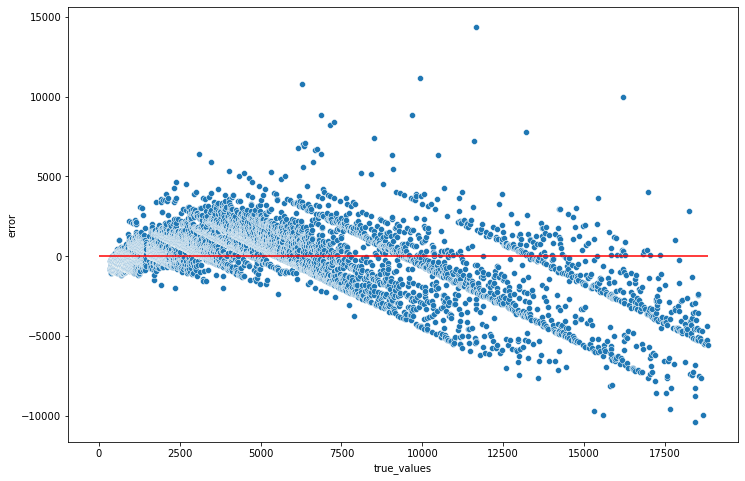

In [21]:
# another way to visualise our errors
p_df = p_df.sort_values(by='true_values')

plt.subplots(figsize=(12, 8))
sns.scatterplot(data=p_df, x='true_values', y='error')
plt.hlines(y=0, xmin=0, xmax=max(p_df['true_values']), color='red')
plt.show()

We can also detect that our model tend to predict worse as the diamonds get more expensive. Maybe we are missing some kind of qualities there. 

## 2nd iteration: Sklearn pipeline + all features

In [22]:
X_train.head()

,carat,cut,color,clarity,depth,table,x,y,z
34530,0.33,Ideal,G,VVS1,62.0,56.0,4.45,4.48,2.77
26173,2.00,Very Good,I,VS2,59.5,62.0,8.13,8.21,4.86
20038,0.30,Good,H,SI1,63.4,58.0,4.21,4.24,2.68
41661,0.54,Ideal,J,VVS1,62.2,54.0,5.23,5.25,3.26
42306,0.41,Premium,D,VVS2,62.5,58.0,4.72,4.75,2.96


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

cat_pipeline = Pipeline(steps=[
    ('one_hot_enc', OneHotEncoder(drop='first'))
])
num_pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])

cat_cols = X_train.select_dtypes('category').columns.tolist()
num_cols = X_train.select_dtypes('float').columns.tolist()
full_processor = ColumnTransformer(transformers=[
    ('number', num_pipeline, num_cols), 
    ('category', cat_pipeline, cat_cols)
])

lm_pipeline = Pipeline(steps=[
    ('processor', full_processor), 
    ('model', LinearRegression())
])

_ = lm_pipeline.fit(X_train, y_train)

In [24]:
lm_pipeline

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z']),
                                                 ('category',
                                                  Pipeline(steps=[('one_hot_enc',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('model', LinearRegression())])


        MSE: 1283144.293193398
        RMSE: 1132.7595919670678
        MAE: 741.8638658324722
        
18823 326


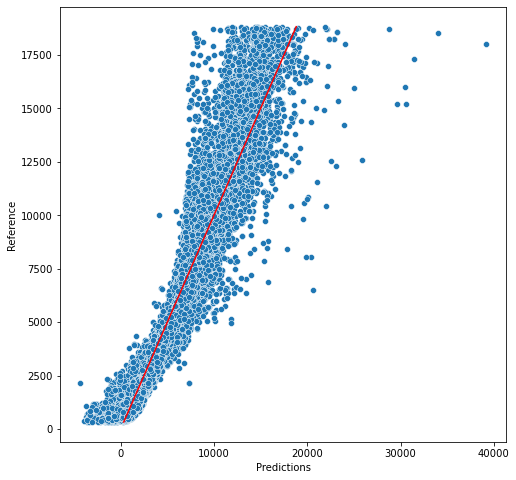

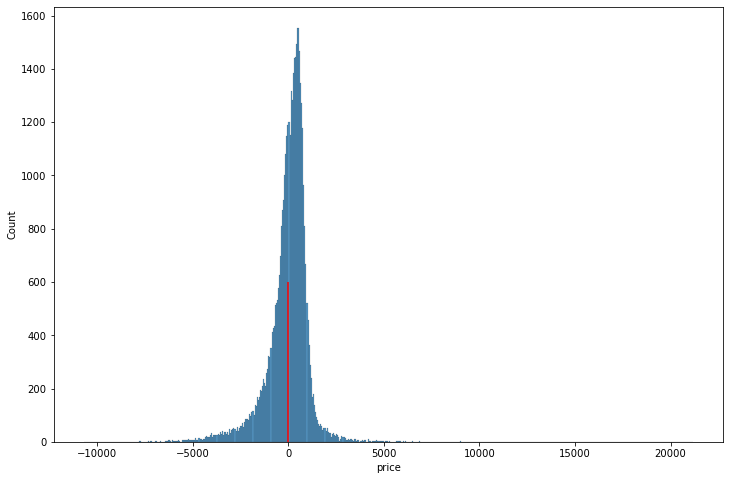

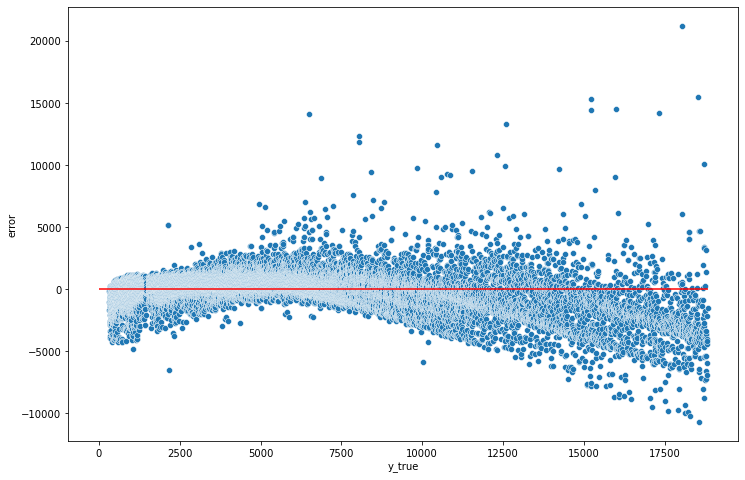

In [25]:
def plot_predictions(y_true, y_pred): 
    print(
        f"""
        MSE: {mean_squared_error(y_true, y_pred)}
        RMSE: {mean_squared_error(y_true, y_pred)**0.5}
        MAE: {mean_absolute_error(y_true, y_pred)}
        """
    )
    max_preds = min([max(y_pred.tolist()), max(y_true.tolist())])
    min_preds = max([min(y_pred.tolist()), min(y_true.tolist())])
    print(max_preds, min_preds)
    # plot
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=y_pred, y=y_true)
    sns.lineplot(x=[min_preds,max_preds], y=[min_preds, max_preds], color='red')
    plt.ylabel('Reference')
    plt.xlabel('Predictions')
    plt.show()

    errors = y_pred - y_true
    plt.subplots(figsize=(12, 8))
    sns.histplot(errors)
    plt.vlines(x=0, ymin=0, ymax=600, color='red')
    plt.show()

    p_df = (
        pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
        .assign(error = lambda x: x['y_pred'] - x['y_true'])
        .sort_values(by='y_true')
        )

    plt.subplots(figsize=(12, 8))
    sns.scatterplot(data=p_df, x='y_true', y='error')
    plt.hlines(y=0, xmin=0, xmax=max(p_df['y_true']), color='red')
    plt.show()

    

# plot_predictions(y_test, results['predictions'])

plot_predictions(y_train, lm_pipeline.predict(X_train))

## 3rd iteration: Logirithm tranformation

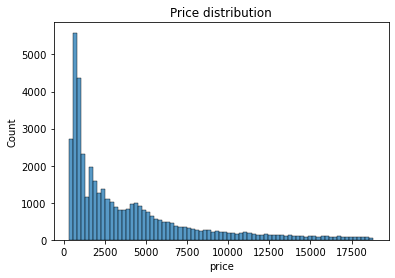

In [26]:
sns.histplot(y_train)
plt.title('Price distribution')
plt.show()

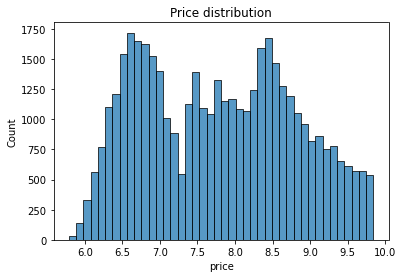

In [27]:
sns.histplot(np.log(y_train))
plt.title('Price distribution')
plt.show()


        MSE: 1262932.743821456
        RMSE: 1123.8028046865945
        MAE: 485.84791717288937
        
18823 326


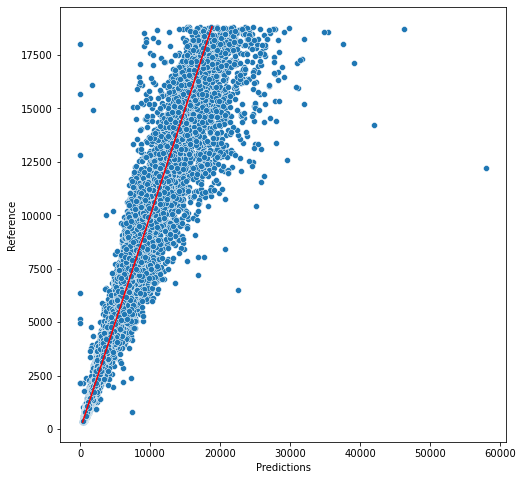

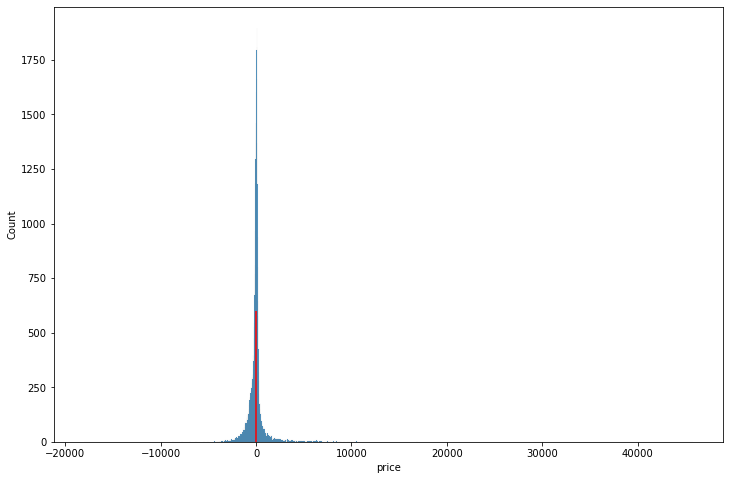

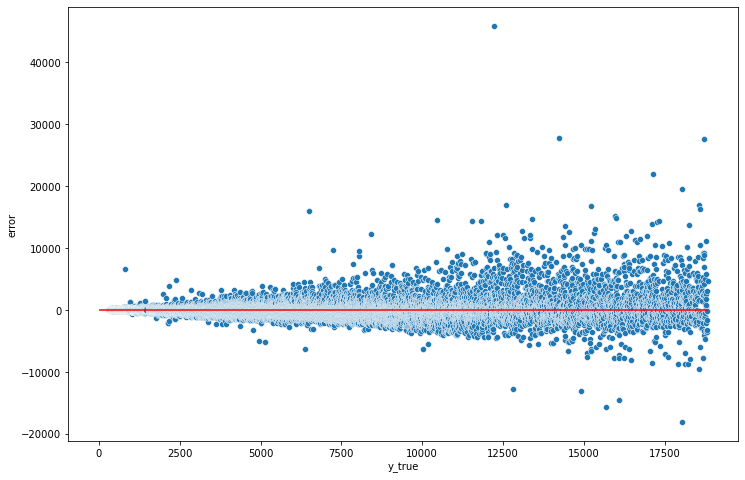

In [28]:
lm_pipeline.fit(X_train, np.log(y_train))
plot_predictions(y_train, np.exp(lm_pipeline.predict(X_train)))

## 5th iteration: exploring correlation


### Correlation Coeficient (Pearson)
![](pearson_correlation_coefficient_formula.png)

![](correlation_coefficient.png)

### Examples

![](Pearson_Correlation_Coefficient_and_associated_scatterplots.png)

More information on wikipedia [link](https://en.wikipedia.org/wiki/Correlation)

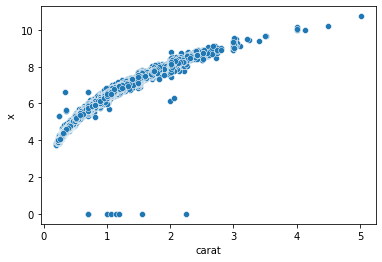

In [29]:
sns.scatterplot(data=X_train, x="carat", y="x")
plt.show()

In [30]:
import numpy as np

X_train_copy = X_train.copy()

X_train_copy['corrn'] = (
    (X_train_copy['carat'] - np.mean(X_train_copy['carat'])) * 
    (X_train_copy['x'] - np.mean(X_train_copy['x']))
)
X_train_copy.head()

X_train_copy['corr1'] = (X_train_copy['carat'] - np.mean(X_train_copy['carat']))**2
X_train_copy.head()

X_train_copy['corr2'] = (X_train_copy['x'] - np.mean(X_train_copy['x']))**2
X_train_copy.head()

corrn = sum(X_train_copy['corrn'])/np.sqrt(sum(X_train_copy['corr1']) * sum(X_train_copy['corr2']))
corrn

0.9743070067185388

In [35]:
# 1. function that given two columns, it returns the corr. coeficient
def corr_coeff(df, var1, var2): 
    temp = df.copy()
    temp['corrn'] = (
        (temp[var1] - np.mean(temp[var1])) * 
        (temp[var2] - np.mean(temp[var2]))
    )
    temp['corr1'] = (temp[var1] - np.mean(temp[var1]))**2
    temp['corr2'] = (temp[var2] - np.mean(temp[var2]))**2
    corrn = sum(temp['corrn'])/np.sqrt(sum(temp['corr1']) * sum(temp['corr2']))
    return corrn


# 2. Calculate the corr_coeficients for all the columns
corr_coeff(X_train, 'carat', 'x')

0.9743070067185388

In [32]:
num_cols = X_train.select_dtypes('float').columns
results = []
for col in num_cols:
    res2 = {}
    for col2 in num_cols:
        r = corr_coeff(X_train, col, col2)
        print(f'r between {col} and {col2} is {r}')
        res2[col2] = r
    results.append(res2)
dfr = pd.DataFrame(pd.json_normalize(results))
dfr.index = num_cols

dfr.head()

r between carat and carat is 1.0
r between carat and depth is 0.02869014807953855
r between carat and table is 0.18450269944791126
r between carat and x is 0.9743070067185388
r between carat and y is 0.9455576131382282
r between carat and z is 0.9490934369872173
r between depth and carat is 0.02869014807953855
r between depth and depth is 1.0
r between depth and table is -0.2975250147896719
r between depth and x is -0.02511872128145794
r between depth and y is -0.0294469010835403
r between depth and z is 0.09450033048363797
r between table and carat is 0.18450269944791126
r between table and depth is -0.2975250147896719
r between table and table is 1.0
r between table and x is 0.19752656889719242
r between table and y is 0.1847276642465391
r between table and z is 0.15254698130039962
r between x and carat is 0.9743070067185388
r between x and depth is -0.02511872128145794
r between x and table is 0.19752656889719242
r between x and x is 1.0
r between x and y is 0.968922725766768
r betw

,carat,depth,table,x,y,z
carat,1.000000,0.028690,0.184503,0.974307,0.945558,0.949093
depth,0.028690,1.000000,-0.297525,-0.025119,-0.029447,0.094500
table,0.184503,-0.297525,1.000000,0.197527,0.184728,0.152547
x,0.974307,-0.025119,0.197527,1.000000,0.968923,0.967107
y,0.945558,-0.029447,0.184728,0.968923,1.000000,0.943991


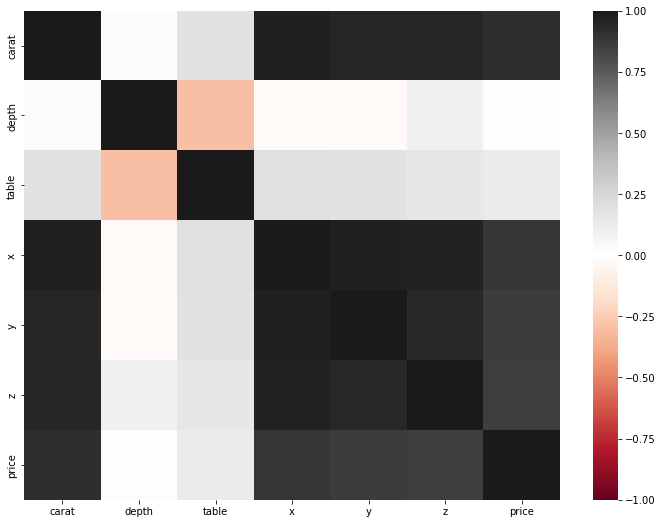

In [33]:
train = pd.concat([X_train, y_train], axis=1)
plt.subplots(figsize=(12, 9))
sns.heatmap(train.corr(), vmin=-1, vmax=1, cmap='RdGy')
plt.show()

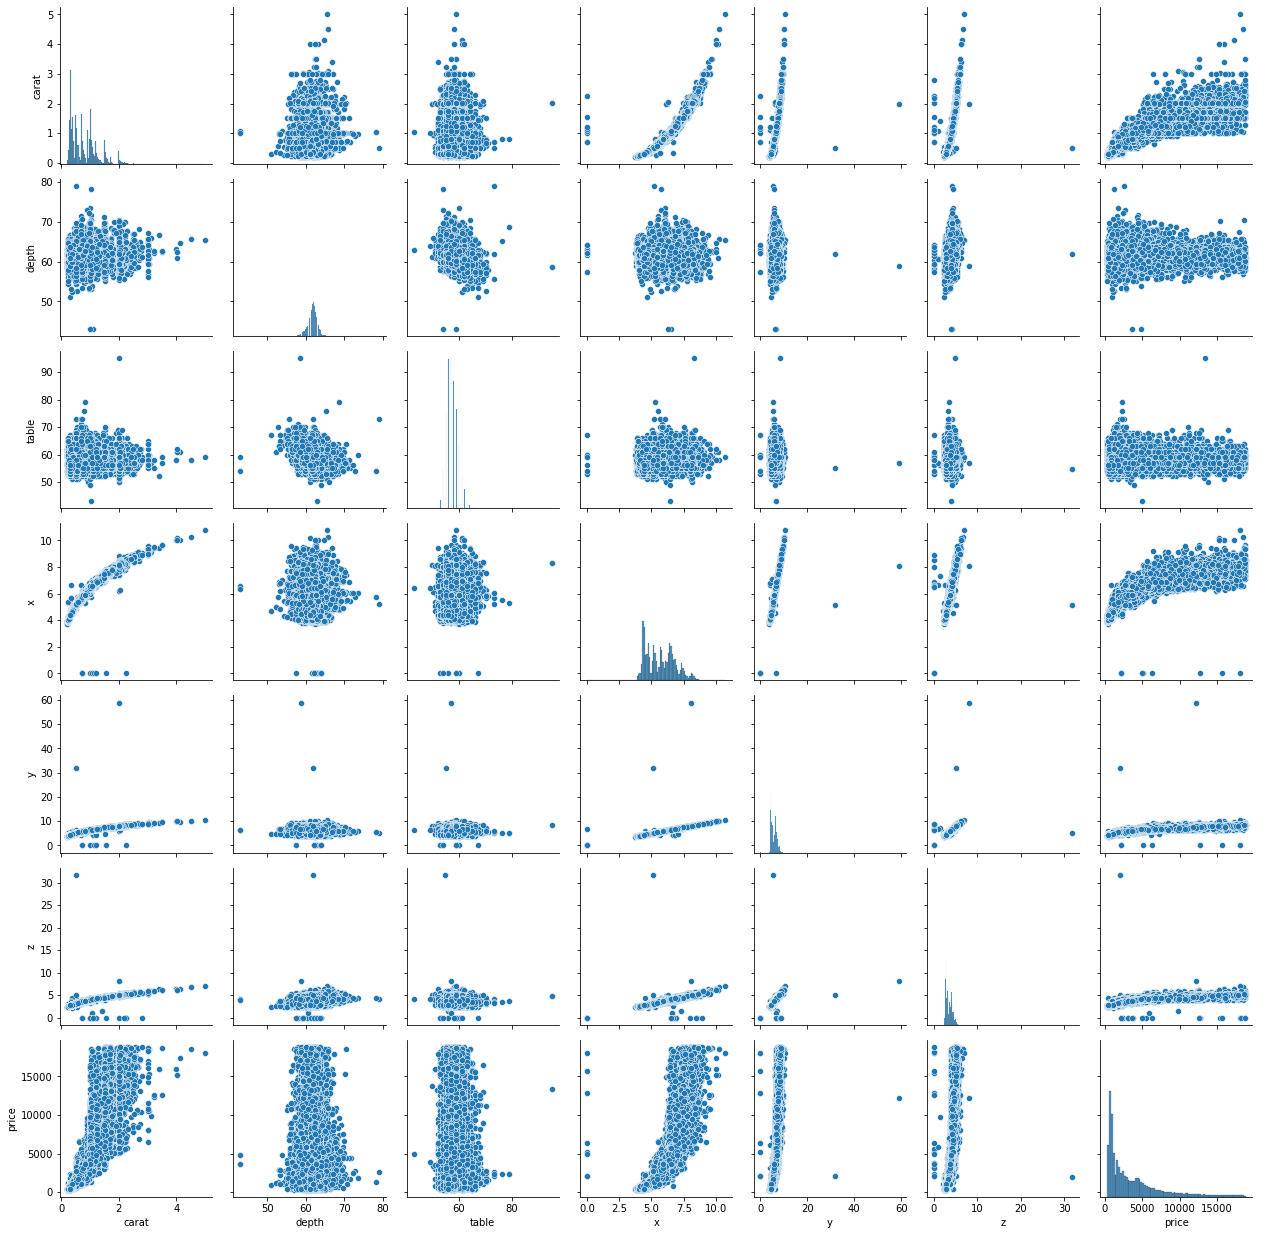

In [34]:
g = sns.PairGrid(train)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

### Problems 

1. [Correlation do not mean causality!](https://www.tylervigen.com/spurious-correlations)
2. Correlation only shows as a linear relation!

![](https://www.researchgate.net/profile/Graeme-Hickey/publication/276360680/figure/fig1/AS:324886896627716@1454470480110/Scatterplots-of-four-different-datasets-known-as-Anscombes-quartet-99-Each-dataset.png)